

## Mounting Google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!unzip "/content/test.csv.zip" -d "/content/drive/MyDrive/cs2/"
#!curl --header "Host: storage.googleapis.com" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.45 Safari/537.36" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-US,en;q=0.9,ta;q=0.8" --header "Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7082/874852/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1638174915&Signature=jeRNGG%2FLlJdTMEiHdrXTEog8ua7K0FDjeKZ4CpuGQWVfs%2Fq3C%2BfuyGn9HoFUA6Mh9MHplkk3NTA2q5a6LLMTfVnBTMcb%2FKYRmpXzT5sFYSQrtI0dJUDtFZu3hsocd0wx%2BurQQ9b8d9hWojc%2BRjC%2FaAC4pCjGnnrt0rcynd%2Be08x2uxSh1r8%2BL24DinOpHpuny1lei%2F%2FlvenRLLpo%2FGKnQ7boWeSlzolSvTbTP5GeLa566POfvZ%2FvSnkSY8fxdbPMun11Aa6eKQ9HJVgl3sj%2BKRyaeSXcldgW8vaH4CB6P%2FpqXbDnrseUx%2FEwd9Zw27dLHtaTxzO1FQ2S%2Fe%2Fa5Ldvgw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip" -L -o "test.csv.zip"

## Importing Libraries

In [13]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import roc_auc_score
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.noise import GaussianDropout
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from keras.wrappers.scikit_learn import KerasClassifier
#from keras.optimizers_v1 import Adam
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, TerminateOnNaN, Callback
import tensorflow as tf

import os
path = os.path.abspath('/content/drive/MyDrive/cs2')

In [6]:
def preprocessing(data,data_type):
  """ 
    This funtion will process the data by using imputation techniques and transofm the data for the model processing

  """
    vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat','id']
    if (data_type=='train'):
        
        data.drop(vars_to_drop, inplace=True, axis=1)

        # Imputing with the mean or mode
        from sklearn.impute import SimpleImputer
        mean_imputer = SimpleImputer(missing_values=-1, strategy='mean')
        mode_imputer = SimpleImputer(missing_values=-1, strategy='most_frequent')


        data['ps_reg_03'] = mean_imputer.fit_transform(data[['ps_reg_03']]).ravel()
        data['ps_car_12'] = mean_imputer.fit_transform(data[['ps_car_12']]).ravel() 
        data['ps_car_14'] = mean_imputer.fit_transform(data[['ps_car_14']]).ravel()


        data['ps_car_11'] = mode_imputer.fit_transform(data[['ps_car_11']]).ravel() 
        data['ps_ind_02_cat'] = mode_imputer.fit_transform(data[['ps_ind_02_cat']]).ravel() 
        data['ps_ind_04_cat'] = mode_imputer.fit_transform(data[['ps_ind_04_cat']]).ravel() 
        data['ps_ind_05_cat'] = mode_imputer.fit_transform(data[['ps_ind_05_cat']]).ravel() 
        data['ps_car_01_cat'] = mode_imputer.fit_transform(data[['ps_car_01_cat']]).ravel() 
        data['ps_car_02_cat'] = mode_imputer.fit_transform(data[['ps_car_02_cat']]).ravel() 
        data['ps_car_07_cat'] = mode_imputer.fit_transform(data[['ps_car_07_cat']]).ravel() 
        data['ps_car_09_cat'] = mode_imputer.fit_transform(data[['ps_car_09_cat']]).ravel()
    
        
    elif(data_type=='test'):
        data.drop(vars_to_drop, inplace=True, axis=1)

    #sc= StandardScaler()    
    #data= sc.fit_transform(data)  
       
    return data


def transform_df(df):
    """ 
    This function creates different features based on the combination and Mean , Meadian , IQR range of the feature

    """
    df = pd.DataFrame(df)
    dcol= [c for c in df.columns if df[c].nunique()>2]
    dcol.remove('id')   
    d_median = df[dcol].median(axis=0)
    d_mean = df[dcol].mean(axis=0)
    q1 = df[dcol].apply(np.float32).quantile(0.25)
    q2 = df[dcol].apply(np.float32).quantile(0.5)
    q3 = df[dcol].apply(np.float32).quantile(0.75)
    
    #Add mean and median column to data set having more then 2 categories
    for c in dcol:
        df[c+str('_median_range')] = (df[c].astype(np.float32).values > d_median[c]).astype(np.int8)
        df[c+str('_mean_range')] = (df[c].astype(np.float32).values > d_mean[c]).astype(np.int8)
        df[c+str('_q1')] = (df[c].astype(np.float32).values < q1[c]).astype(np.int8)
        df[c+str('_q2')] = (df[c].astype(np.float32).values < q2[c]).astype(np.int8)
        df[c+str('_q3')] = (df[c].astype(np.float32).values > q3[c]).astype(np.int8)
    return df


In [7]:
class roc_auc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        """y_pred_te = self.model.predict(self.x, verbose=0)
        y_pred = [round(x[0]) for x in y_pred_te]
        roc = roc_auc_score(self.y, y_pred)
        logs['roc_auc'] = roc_auc_score(self.y, y_pred)
        logs['norm_gini'] = ( roc_auc_score(self.y, y_pred) * 2 ) - 1"""

        y_pred_val_v = self.model.predict(self.x_val, verbose=0)
        y_pred_val = [round(x[0]) for x in y_pred_val_v]
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        logs['roc_auc_val'] = roc_auc_score(self.y_val, y_pred_val)
        logs['norm_gini_val'] = ( roc_auc_score(self.y_val, y_pred_val) * 2 ) - 1

        #print('\rroc_auc: %s - roc_auc_val: %s - norm_gini: %s - norm_gini_val: %s' % (str(round(roc,5)),str(round(roc_val,5)),str(round((roc*2-1),5)),str(round((roc_val*2-1),5))), end=10*' '+'\n')
        print('\rroc_auc_val: %s - norm_gini_val: %s' % (str(round(roc_val,5)),str(round(((roc_val*2)-1),5))), end=10*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

def labels_anotate(data):
    """
      This function is used for anotate the labels in the plot

    """

    cmt=[]
    for i in range(0,2):
        for j in range(0,2):
            if(i==0 and j==0):
                cmt.append(str(data[i][j]) + "   True Negative")
            if(i==0 and j==1):
                cmt.append(str(data[i][j]) + "   False Positive")
            if(i==1 and j==0):
                cmt.append(str(data[i][j]) + "   False Negative")
            if(i==1 and j==1):
                cmt.append(str(data[i][j]) + "   True Positive")

    return cmt

## Reading Data

In [53]:
data = pd.read_csv('/content/drive/MyDrive/cs2/train.csv')
test_data=pd.read_csv('/content/drive/MyDrive/cs2/test.csv')
print("Shape of the input data  : ",data.shape)

Shape of the input data  :  (595212, 59)




## Train Test Split and Feature transform

In [9]:
from sklearn.model_selection import train_test_split
train = transform_df(data)
x=train.drop('target',axis=1)
y=train['target']
# Creating training and validation sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((476169, 253), (119043, 253), (476169,), (119043,))

* We transformed the data from 58 features excluding the target into 253 features after applying feature transformation.

## Upsampling the data

In [10]:
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(x_train, y_train)
y_train=y_over
x_train=preprocessing(X_over,'train')
x_test=preprocessing(x_test,'test')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((917572, 250), (119043, 250), (917572,), (119043,))

#  Machine Learning and Deep Learning Models

## XGboost model to get the Feature Importance

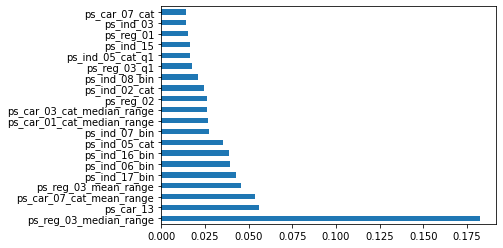

In [11]:
import xgboost
from xgboost import XGBClassifier
from matplotlib import pyplot

# define the model
model = XGBClassifier(n_estimators=10,
 max_depth= 6)

# fit the model
model.fit(x_train,y_train)
# get importance
importance = model.feature_importances_

# plot feature importance
## Reference : https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


In [51]:
# Selecting the important features based on feature importance values
print("The top 75 features contains variance = ",feat_importances.nlargest(75).values.sum())
lst=feat_importances.nlargest(75).index
x_train=x_train.filter(lst)
x_test=x_test.filter(lst)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

The top 75 features contains variance =  1.0000001


((917572, 75), (119043, 75), (917572,), (119043,))

### Observation
* From the xgboost model we have calculated the feature importance as we see the top 75 features contains 100 % variance so for further processing we can consider the Top 75 features droping other features.

## Logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


In [ ]:
Logistic_classifier=LogisticRegression()
parms = {'C':[0.001,0.01,1,10,100]}
clf=GridSearchCV(Logistic_classifier,parms,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(x_train,y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)

In [ ]:
train_auc=clf.cv_results_['mean_train_score']
test_auc=clf.cv_results_['mean_test_score']


results = pd.DataFrame.from_dict(clf.cv_results_)
bestScore=clf.best_score_

print("Best Score: " , bestScore )
results

Best Score:  0.6275276838444529


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,22.784592,0.713437,0.245048,0.002579,0.001,{'C': 0.001},0.626079,0.627548,0.627176,0.626935,0.000623,5,0.627811,0.626611,0.627152,0.627191,0.000490
1,23.344298,0.040536,0.237269,0.001978,0.01,{'C': 0.01},0.626878,0.627581,0.626993,0.627150,0.000308,4,0.628536,0.626618,0.627119,0.627424,0.000812
2,23.626484,0.029426,0.238956,0.002276,1,{'C': 1},0.627453,0.627726,0.627016,0.627399,0.000293,3,0.629185,0.626860,0.627084,0.627710,0.001047
3,23.467679,0.158456,0.238424,0.006510,10,{'C': 10},0.627131,0.628167,0.627286,0.627528,0.000456,1,0.628856,0.627285,0.627341,0.627827,0.000728
4,23.275859,0.101401,0.242944,0.006270,100,{'C': 100},0.627172,0.628494,0.626844,0.627503,0.000713,2,0.628875,0.627564,0.626856,0.627765,0.000836


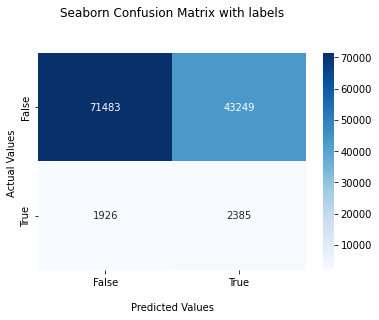

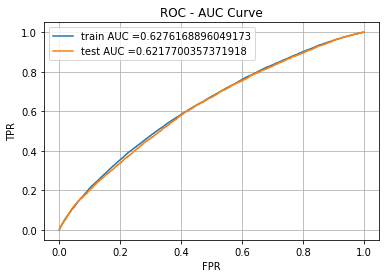

Gini impurity value : 0.2435400714743836


In [ ]:

Logistic_classifier= LogisticRegression(random_state=42,C=0.001)  
Logistic_classifier.fit(x_train, y_train)  

 
y_pred= Logistic_classifier.predict(x_test) 

cnf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cnf_matrix, annot=True,fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

y_train_pred=Logistic_classifier.predict_proba(x_train)[:,1]
y_test_pred=Logistic_classifier.predict_proba(x_test)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - AUC Curve")
plt.grid()
plt.show()
print("Gini impurity value :",( roc_auc_score(y_test, y_test_pred) * 2 ) - 1)

## Observation 
* Logistic regression is the basic model for 2 class classification and here we can see the LR model after hyperparameter tuning will able to classify our data well and we are able to achecive the Gini impurity of 0.243.
* LR models will take less training time but gies us better results.

## Decision tree Classifier

In [ ]:
Decision_tree=DecisionTreeClassifier(class_weight='balanced')
parms = {'max_depth':[1, 5, 10],'min_samples_split':[5, 10, 100]}
clf=RandomizedSearchCV(Decision_tree,parms,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(x_train,y_train)


train_auc=clf.cv_results_['mean_train_score']
test_auc=clf.cv_results_['mean_test_score']


results = pd.DataFrame.from_dict(clf.cv_results_)
MaxDepth=clf.best_params_['max_depth']
MinSampleSplit=clf.best_params_['min_samples_split']
bestScore=clf.best_score_

print("Best Score: " , bestScore ,"\nMax Depth",MaxDepth,"\nMinimun Split ",MinSampleSplit)




Best Score:  0.6736506623863874 
Max Depth 10 
Minimun Split  10


Text(0.5, 1.0, 'Cross Validation Set')

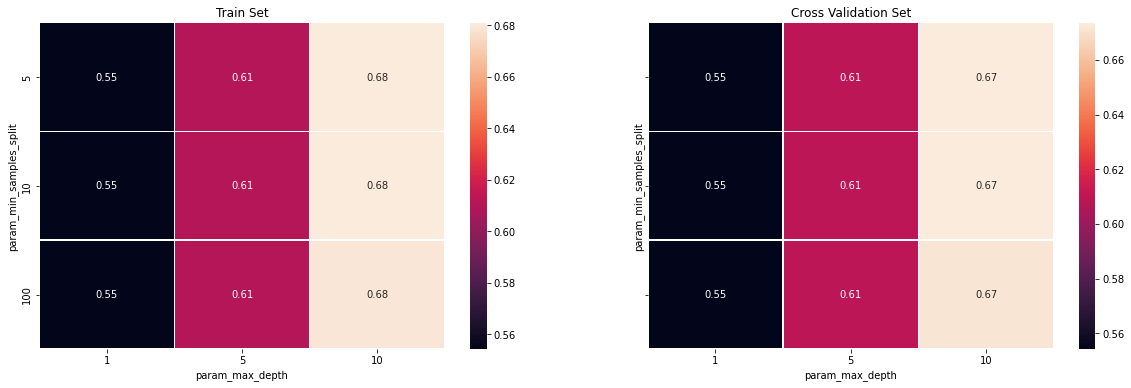

In [ ]:
#df=results['param_min_samples_split','param_max_depth','mean_test_score']
df_train = pd.DataFrame(results, columns=['param_min_samples_split','param_max_depth', 'mean_train_score'])
df_test = pd.DataFrame(results, columns=['param_min_samples_split','param_max_depth', 'mean_test_score'])
df_train = df_train.pivot_table( index='param_min_samples_split', columns='param_max_depth', values='mean_train_score')
df_test = df_test.pivot_table( index='param_min_samples_split', columns='param_max_depth', values='mean_test_score')

fig, ax = plt.subplots(1,2, figsize=(20,6),sharey=True)
sns.heatmap(data=df_train,annot=True,linewidths=.5,ax=ax[0])
sns.heatmap(data=df_test,annot=True,linewidths=.5,ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Cross Validation Set')

Test confusion matrix


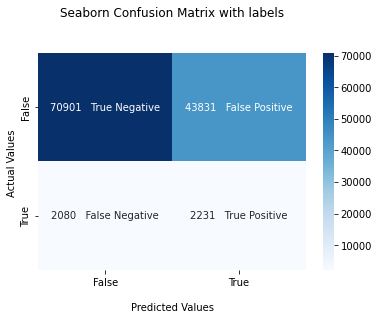

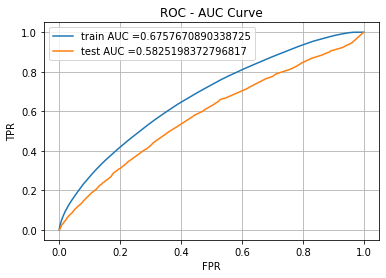

Gini impurity value : 0.16503967455936341


In [ ]:

Decision_tree=DecisionTreeClassifier(max_depth=MaxDepth,min_samples_split=MinSampleSplit)
model=Decision_tree.fit(x_train, y_train)  


y_pred= model.predict(x_test) 

print("Test confusion matrix")
labels = [["True Negative","False positive"],["False Negative","True Poistive"]]
test_c=confusion_matrix(y_test, y_pred)
cmtr = np.array([[test_c[0][0],test_c[0][1]],[test_c[1][0],test_c[1][1]]])
cmt=np.array(labels_anotate(cmtr))
cmt=cmt.reshape(2,2)

ax=sns.heatmap(cmtr, annot=cmt,fmt="s",cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

y_train_pred=model.predict_proba(x_train)[:,1]
y_test_pred=model.predict_proba(x_test)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_over, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - AUC Curve")
plt.grid()
plt.show()

print("Gini impurity value :",( roc_auc_score(y_test, y_test_pred) * 2 ) - 1)

## Observation 
* Here we tried with simple decision tree classifier as these models will perform well with two class classification as we see our Gini values is less than 0.20 which is not expected but with some advanced models we can improve this score to achieve better results.

## Gradient Boosting Decision Tree -GBDT

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GBDT=GradientBoostingClassifier()
parms = {'max_depth':[5,10],'n_estimators':[5,10]}
clf=GridSearchCV(GBDT,parms,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(x_train,y_train)


train_auc=clf.cv_results_['mean_train_score']
test_auc=clf.cv_results_['mean_test_score']


results = pd.DataFrame.from_dict(clf.cv_results_)
MaxDepth=clf.best_params_['max_depth']
N_estimators=clf.best_params_['n_estimators']
bestScore=clf.best_score_

print("Best Score: " , bestScore ,"\nMax Depth",MaxDepth,"\nNumber of Estimators ",N_estimators)

Best Score:  0.7677454152381755 
Max Depth 10 
Number of Estimators  10


Text(0.5, 1.0, 'Cross Validation Set')

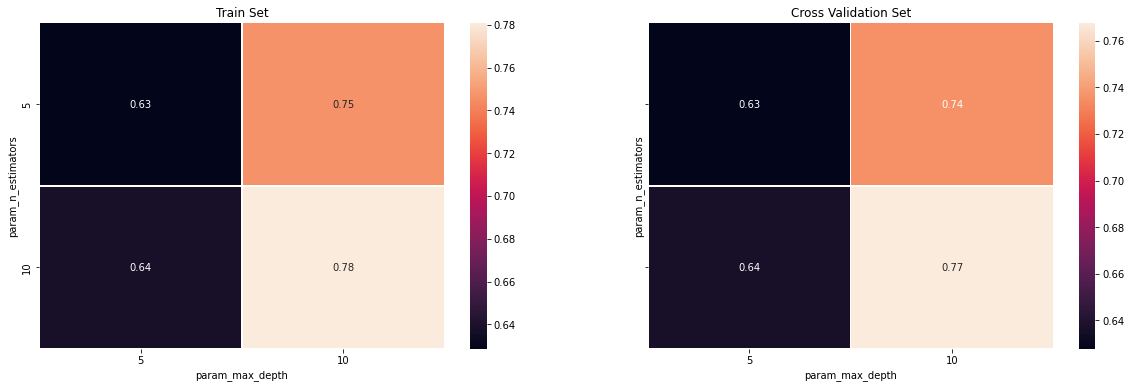

In [ ]:
df_train = pd.DataFrame(results, columns=['param_n_estimators','param_max_depth', 'mean_train_score'])
df_test = pd.DataFrame(results, columns=['param_n_estimators','param_max_depth', 'mean_test_score'])
df_train = df_train.pivot_table( index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
df_test = df_test.pivot_table( index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

fig, ax = plt.subplots(1,2, figsize=(20,6),sharey=True)
sns.heatmap(data=df_train,annot=True,linewidths=.5,ax=ax[0])
sns.heatmap(data=df_test,annot=True,linewidths=.5,ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Cross Validation Set')

Test confusion matrix


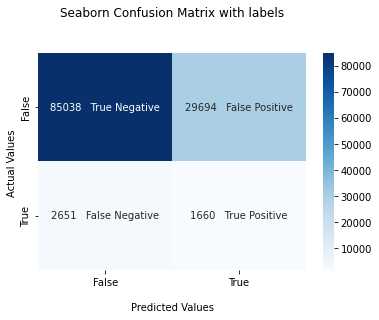

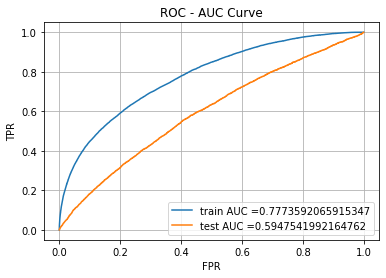

Gini impurity value : 0.18950839843295242


In [ ]:

GBDT=GradientBoostingClassifier(max_depth=MaxDepth,n_estimators=N_estimators)
model=GBDT.fit(x_train, y_train)  


y_pred= model.predict(x_test) 

print("Test confusion matrix")
labels = [["True Negative","False positive"],["False Negative","True Poistive"]]
test_c=confusion_matrix(y_test, y_pred)
cmtr = np.array([[test_c[0][0],test_c[0][1]],[test_c[1][0],test_c[1][1]]])
cmt=np.array(labels_anotate(cmtr))
cmt=cmt.reshape(2,2)

ax=sns.heatmap(cmtr, annot=cmt,fmt="s",cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

y_train_pred=model.predict_proba(x_train)[:,1]
y_test_pred=model.predict_proba(x_test)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_over, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - AUC Curve")
plt.grid()
plt.show()
print("Gini impurity value :",( roc_auc_score(y_test, y_test_pred) * 2 ) - 1)

## Observation
* When we use GBDt this is the boosting classifier we can see the results are getting improved , we are getting better AUC value and the Gini impurity value is increased when compared to simple Decision Tree.

## XGBOOST

Best Score:  0.7634487203814722 
Max Depth 9 
Number of Estimators  20


Text(0.5, 1.0, 'Cross Validation Set')

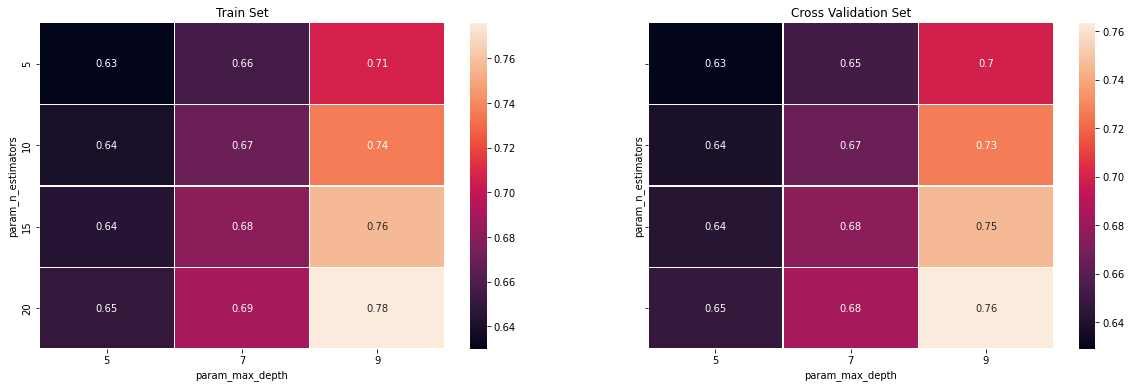

In [18]:
import xgboost as xgb
XGB=xgb.XGBClassifier(random_state=42)
parms = {'max_depth':[5,7,9],'n_estimators':[5,10,15,20]}
clf=GridSearchCV(XGB,parms,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(x_train,y_train)


train_auc=clf.cv_results_['mean_train_score']
test_auc=clf.cv_results_['mean_test_score']


results = pd.DataFrame.from_dict(clf.cv_results_)
MaxDepth=clf.best_params_['max_depth']
N_estimators=clf.best_params_['n_estimators']
bestScore=clf.best_score_

print("Best Score: " , bestScore ,"\nMax Depth",MaxDepth,"\nNumber of Estimators ",N_estimators)


df_train = pd.DataFrame(results, columns=['param_n_estimators','param_max_depth', 'mean_train_score'])
df_test = pd.DataFrame(results, columns=['param_n_estimators','param_max_depth', 'mean_test_score'])
df_train = df_train.pivot_table( index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
df_test = df_test.pivot_table( index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

fig, ax = plt.subplots(1,2, figsize=(20,6),sharey=True)
sns.heatmap(data=df_train,annot=True,linewidths=.5,ax=ax[0])
sns.heatmap(data=df_test,annot=True,linewidths=.5,ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Cross Validation Set')

Test confusion matrix


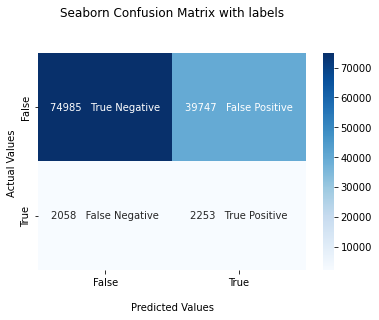

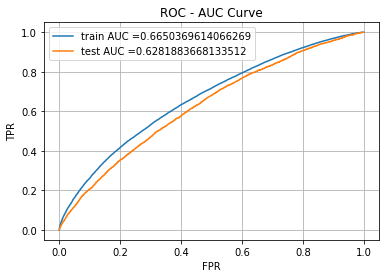

Gini impurity value : 0.25637673362670244


In [20]:
import xgboost as xgb
XGB=xgb.XGBClassifier(n_estimators=20,
 max_depth= 6
)
model=XGB.fit(x_train, y_train)  


y_pred= model.predict(x_test) 

print("Test confusion matrix")
labels = [["True Negative","False positive"],["False Negative","True Poistive"]]
test_c=confusion_matrix(y_test, y_pred)
cmtr = np.array([[test_c[0][0],test_c[0][1]],[test_c[1][0],test_c[1][1]]])
cmt=np.array(labels_anotate(cmtr))
cmt=cmt.reshape(2,2)

ax=sns.heatmap(cmtr, annot=cmt,fmt="s",cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()




y_test_pred=model.predict_proba(x_test)[:,1]
y_train_pred=model.predict_proba(x_train)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - AUC Curve")
plt.grid()
plt.show()
print("Gini impurity value :",( roc_auc_score(y_test, y_test_pred) * 2 ) - 1)

## Observation
* XGBoost is the advanced models in Decision tree as this involes both row and column sampling techniques to implement randomness in the data as we see this is te better model when compared with all other as the Gini impurity values raised to 0.256 and we got better AUC with the Test data.

## Light GBM model

Best Score:  0.7058791282483815 
Max Depth 15 
Number of Estimators  100


Text(0.5, 1.0, 'Cross Validation Set')

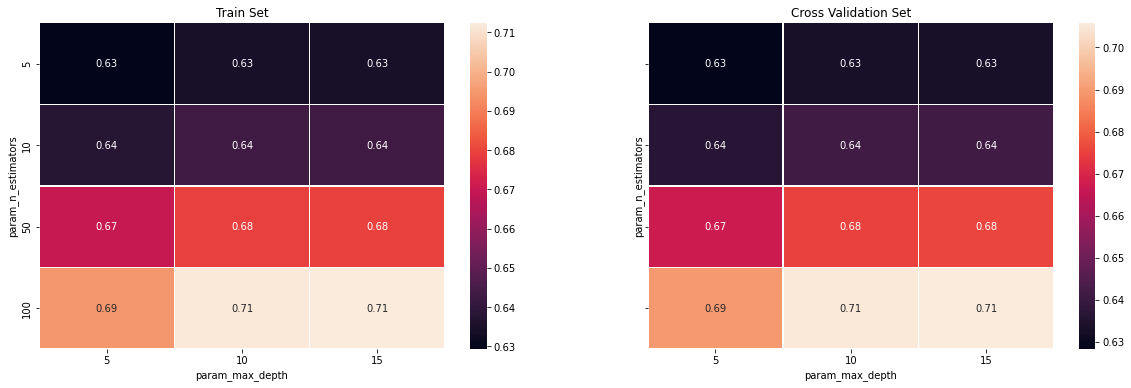

In [21]:
import lightgbm as lgb
LGB=lgb.LGBMClassifier(random_state=42)
parms = {'max_depth':[5,10,15],'n_estimators':[5,10,50,100]}
clf=GridSearchCV(LGB,parms,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(x_train,y_train)


train_auc=clf.cv_results_['mean_train_score']
test_auc=clf.cv_results_['mean_test_score']


results = pd.DataFrame.from_dict(clf.cv_results_)
MaxDepth=clf.best_params_['max_depth']
N_estimators=clf.best_params_['n_estimators']
bestScore=clf.best_score_

print("Best Score: " , bestScore ,"\nMax Depth",MaxDepth,"\nNumber of Estimators ",N_estimators)


df_train = pd.DataFrame(results, columns=['param_n_estimators','param_max_depth', 'mean_train_score'])
df_test = pd.DataFrame(results, columns=['param_n_estimators','param_max_depth', 'mean_test_score'])
df_train = df_train.pivot_table( index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
df_test = df_test.pivot_table( index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

fig, ax = plt.subplots(1,2, figsize=(20,6),sharey=True)
sns.heatmap(data=df_train,annot=True,linewidths=.5,ax=ax[0])
sns.heatmap(data=df_test,annot=True,linewidths=.5,ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Cross Validation Set')

Test confusion matrix


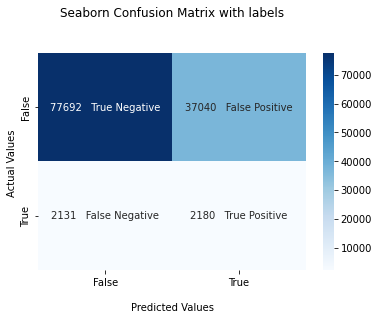

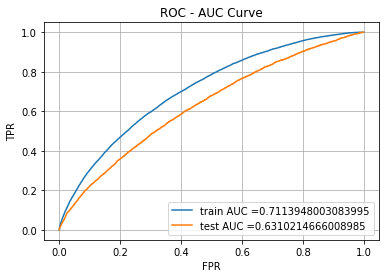

Gini impurity value : 0.26204293320179706


In [22]:
import lightgbm as lgb
LGBM=lgb.LGBMClassifier(n_estimators=100,
 max_depth= 15
)
model=LGBM.fit(x_train, y_train)  


y_pred= LGBM.predict(x_test) 

print("Test confusion matrix")
labels = [["True Negative","False positive"],["False Negative","True Poistive"]]
test_c=confusion_matrix(y_test, y_pred)
cmtr = np.array([[test_c[0][0],test_c[0][1]],[test_c[1][0],test_c[1][1]]])
cmt=np.array(labels_anotate(cmtr))
cmt=cmt.reshape(2,2)

ax=sns.heatmap(cmtr, annot=cmt,fmt="s",cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

y_test_pred=model.predict_proba(x_test)[:,1]
y_train_pred=model.predict_proba(x_train)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - AUC Curve")
plt.grid()
plt.show()
print("Gini impurity value :",( roc_auc_score(y_test, y_test_pred) * 2 ) - 1)

## Observation
* LIGHT GBM performs well with our data we are able to achieve better results as Gini values is 0.262 and AUC is 0.63 and this has some advantage over XGBOOST as the training time is very less comepared to other models.

## Random Forest Classifier

In [23]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
RFC=RandomForestClassifier(random_state=42)
parms = {'max_depth':[5,10],'n_estimators':[10,100]}
clf=GridSearchCV(RFC,parms,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(x_train,y_train)


train_auc=clf.cv_results_['mean_train_score']
test_auc=clf.cv_results_['mean_test_score']


results = pd.DataFrame.from_dict(clf.cv_results_)
MaxDepth=clf.best_params_['max_depth']
N_estimators=clf.best_params_['n_estimators']
bestScore=clf.best_score_

print("Best Score: " , bestScore ,"\nMax Depth",MaxDepth,"\nNumber of Estimators ",N_estimators)

Best Score:  0.7290929562720908 
Max Depth 10 
Number of Estimators  100


Text(0.5, 1.0, 'Cross Validation Set')

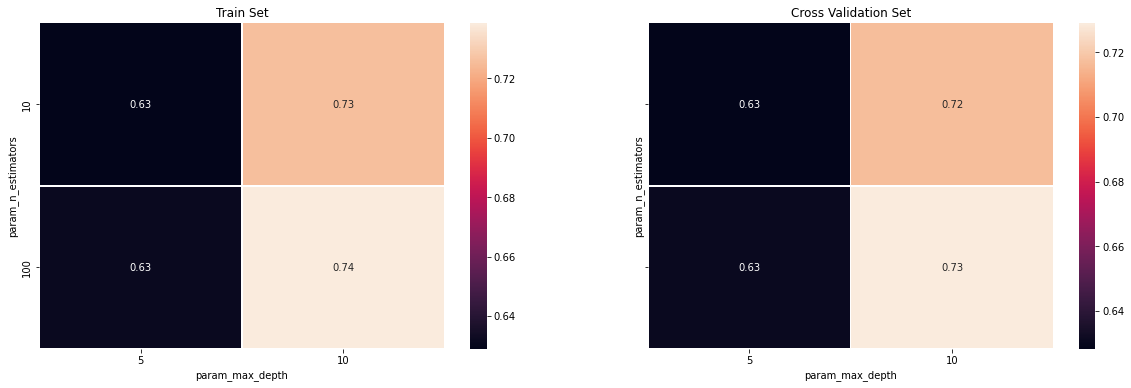

In [24]:
df_train = pd.DataFrame(results, columns=['param_n_estimators','param_max_depth', 'mean_train_score'])
df_test = pd.DataFrame(results, columns=['param_n_estimators','param_max_depth', 'mean_test_score'])
df_train = df_train.pivot_table( index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
df_test = df_test.pivot_table( index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

fig, ax = plt.subplots(1,2, figsize=(20,6),sharey=True)
sns.heatmap(data=df_train,annot=True,linewidths=.5,ax=ax[0])
sns.heatmap(data=df_test,annot=True,linewidths=.5,ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Cross Validation Set')

Test confusion matrix


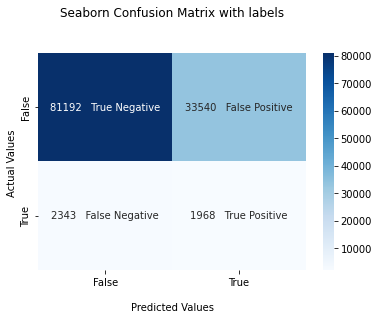

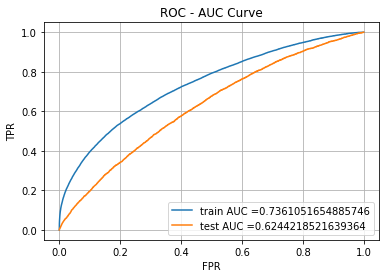

Gini impurity value : 0.24884370432787284


In [25]:
from sklearn.ensemble import RandomForestClassifier
RFC=RandomForestClassifier(max_depth=10,n_estimators=100,n_jobs=-1)
model=RFC.fit(x_train, y_train)  


y_pred= model.predict(x_test) 

print("Test confusion matrix")
labels = [["True Negative","False positive"],["False Negative","True Poistive"]]
test_c=confusion_matrix(y_test, y_pred)
cmtr = np.array([[test_c[0][0],test_c[0][1]],[test_c[1][0],test_c[1][1]]])
cmt=np.array(labels_anotate(cmtr))
cmt=cmt.reshape(2,2)

ax=sns.heatmap(cmtr, annot=cmt,fmt="s",cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

y_train_pred=model.predict_proba(x_train)[:,1]
y_test_pred=model.predict_proba(x_test)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_over, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - AUC Curve")
plt.grid()
plt.show()
print("Gini impurity value :",( roc_auc_score(y_test, y_test_pred) * 2 ) - 1)

## Observation
* Random forest is the bagging techniques which is used for classification , and which is giving us the AUC of 0.62 and the Gini value of 0.248 but this model still not able to perform well with our data.

## DEEP NEURAL NETWORK MODELS

### Deep learning Model -1

In [15]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

In [27]:
x_train.values.shape,x_test.values.shape

((917572, 75), (119043, 75))

In [16]:
# Basic Deep learning Model

model = Sequential()
model.add(Dense(50, input_dim=75, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# Compile model
model.compile( optimizer='adam',
                        loss='binary_crossentropy' )

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


In [31]:
callbacks = [roc_auc_callback(training_data=(x_train.values, y_train),validation_data=(x_test.values, y_test))]
model.fit(x_train.values, y_train, epochs=15, verbose=1, batch_size=50,callbacks=callbacks)

Epoch 1/15
roc_auc_val: 0.58629 - norm_gini_val: 0.17259          
18352/18352 [==============================] - 27s 1ms/step - loss: 0.6695 - roc_auc_val: 0.5863 - norm_gini_val: 0.1726
Epoch 2/15
roc_auc_val: 0.58345 - norm_gini_val: 0.16689          
18352/18352 [==============================] - 27s 1ms/step - loss: 0.6586 - roc_auc_val: 0.5834 - norm_gini_val: 0.1669
Epoch 3/15
roc_auc_val: 0.58244 - norm_gini_val: 0.16489          
18352/18352 [==============================] - 27s 1ms/step - loss: 0.6505 - roc_auc_val: 0.5824 - norm_gini_val: 0.1649
Epoch 4/15
roc_auc_val: 0.57771 - norm_gini_val: 0.15542          
18352/18352 [==============================] - 27s 1ms/step - loss: 0.6425 - roc_auc_val: 0.5777 - norm_gini_val: 0.1554
Epoch 5/15
roc_auc_val: 0.57765 - norm_gini_val: 0.1553          
18352/18352 [==============================] - 27s 1ms/step - loss: 0.6368 - roc_auc_val: 0.5777 - norm_gini_val: 0.1553
Epoch 6/15
roc_auc_val: 0.57136 - norm_gini_val: 0.14273     

Test confusion matrix


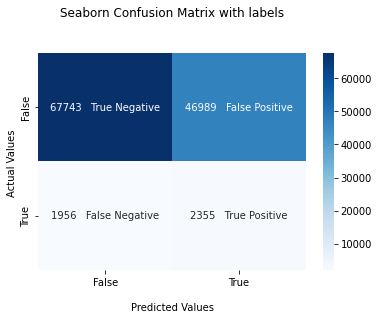

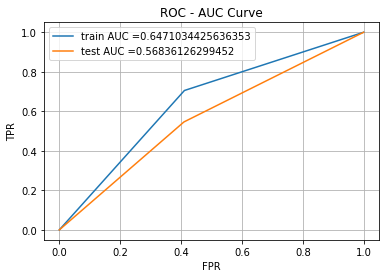

Gini impurity value : 0.1367225259890399


In [33]:
predictions = model.predict(x_test)
train_pred= model.predict(x_train)
#round the prediction
y_pred = [round(x[0]) for x in predictions]

#round the prediction
y_pred_train = [round(x[0]) for x in train_pred]
print("Test confusion matrix")
labels = [["True Negative","False positive"],["False Negative","True Poistive"]]
test_c=confusion_matrix(y_test, y_pred)
cmtr = np.array([[test_c[0][0],test_c[0][1]],[test_c[1][0],test_c[1][1]]])
cmt=np.array(labels_anotate(cmtr))
cmt=cmt.reshape(2,2)

ax=sns.heatmap(cmtr, annot=cmt,fmt="s",cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - AUC Curve")
plt.grid()
plt.show()

print("Gini impurity value :",( roc_auc_score(y_test, y_pred) * 2 ) - 1)

## Observation
* As our machine learning models performs well with our data we will try some advance deep leaning models to quantify our data.
* We can observe that the Simple DL models not able to perform with our data and its gib=ving very low Gini impurity value that is 0.136.

### Deep Learning Model -2

In [17]:

model = Sequential()
model.add(Dense(200, input_dim=75, kernel_initializer='glorot_normal',
                kernel_regularizer=regularizers.l2(0.001)))
model.add(PReLU())
model.add(BatchNormalization())
model.add(GaussianDropout(0.4))
        
model.add(Dense(100, kernel_initializer='glorot_normal',
                        kernel_regularizer=regularizers.l2(0.00001)))
model.add(PReLU())
model.add(BatchNormalization())
model.add(GaussianDropout(0.3))
        
model.add(Dense(50, kernel_initializer='glorot_normal',
                       kernel_regularizer=regularizers.l2(0.00001)))
model.add(PReLU())
model.add(BatchNormalization())
model.add(GaussianDropout(0.25))
        
model.add(Dense(30, kernel_initializer='glorot_normal',
                  kernel_regularizer=regularizers.l2(0.00001)))
model.add(PReLU())
model.add(BatchNormalization())
model.add(GaussianDropout(0.3))

model.add(Dense(20, kernel_initializer='glorot_normal',
                  kernel_regularizer=regularizers.l2(0.00001)))
model.add(PReLU())
model.add(BatchNormalization())
model.add(GaussianDropout(0.3))

model.add(Dense(10, kernel_initializer='glorot_normal',
                  kernel_regularizer=regularizers.l2(0.00001)))
model.add(PReLU())
model.add(BatchNormalization())
model.add(GaussianDropout(0.3))
        
model.add(Dense(5, kernel_initializer='glorot_normal',
                 kernel_regularizer=regularizers.l2(0.00001)))
model.add(PReLU())
model.add(BatchNormalization())
model.add(GaussianDropout(0.2))
        
model.add(Dense(1, activation='sigmoid'))



# Compile model
model.compile( optimizer='adam',
                        loss='binary_crossentropy' )

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 200)               15200     
_________________________________________________________________
p_re_lu_49 (PReLU)           (None, 200)               200       
_________________________________________________________________
module_wrapper_108 (ModuleWr (None, 200)               800       
_________________________________________________________________
gaussian_dropout_49 (Gaussia (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               20100     
_________________________________________________________________
p_re_lu_50 (PReLU)           (None, 100)               100       
_________________________________________________________________
module_wrapper_109 (ModuleWr (None, 100)             

In [11]:
# Compile model
model.compile( optimizer='adam',
                        loss='binary_crossentropy' )
import keras
#model.load_weights(os.path.join(path, 'cs2.h5'))
#keras.backend.set_value(model.optimizer.lr, .00001)
callbacks = [roc_auc_callback(training_data=(x_train, y_train),validation_data=(x_test, y_test))]
model.fit(x_train, y_train, epochs=10, verbose=1, batch_size=512,callbacks=callbacks)
model.save_weights(os.path.join(path, 'cs2.h5'))

NameError: name 'roc_auc_callback' is not defined

Test confusion matrix


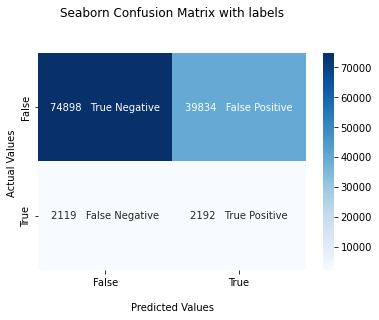

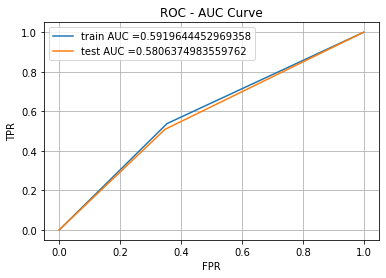

Gini impurity value : 0.16127499671195245


In [43]:
predictions = model.predict(x_test)
train_pred= model.predict(x_train)
#round the prediction
y_pred = [round(x[0]) for x in predictions]

#round the prediction
y_pred_train = [round(x[0]) for x in train_pred]
print("Test confusion matrix")
labels = [["True Negative","False positive"],["False Negative","True Poistive"]]
test_c=confusion_matrix(y_test, y_pred)
cmtr = np.array([[test_c[0][0],test_c[0][1]],[test_c[1][0],test_c[1][1]]])
cmt=np.array(labels_anotate(cmtr))
cmt=cmt.reshape(2,2)

ax=sns.heatmap(cmtr, annot=cmt,fmt="s",cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - AUC Curve")
plt.grid()
plt.show()

print("Gini impurity value :",( roc_auc_score(y_test, y_pred) * 2 ) - 1)

## Observation
* We can see that when we added more layers with our DL model , our models performs better but still model is not able to acheive better results with our data .
* This model can able to get Gini value of 0.161.

In [54]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Train AUC", "Test AUC","Gini Impurity Value"]
x.add_row(["Logistic Regression", 0.627,0.621,0.243] )
x.add_row(["Decision Tree Classifier", 0.675,0.582,0.165] )
x.add_row(["Gradient Boosting Decision Tree", 0.777,0.584,0.195] )
x.add_row(["Xtreme Gradient Bossting - XGBOOST ", 0.665,0.628,0.256] )
x.add_row(["Light - GBM ", 0.711,0.631,0.262] )
x.add_row(["Random Forest Classifier ", 0.736,0.624,0.248] )
x.add_row(["Deep Learning Simple Model", 0.647,0.568,0.138] )
x.add_row(["Deep Learning Advanced Model", 0.591,0.580,0.161] )

print("Results")
print(x)

Results
+-------------------------------------+-----------+----------+---------------------+
|                Model                | Train AUC | Test AUC | Gini Impurity Value |
+-------------------------------------+-----------+----------+---------------------+
|         Logistic Regression         |   0.627   |  0.621   |        0.243        |
|       Decision Tree Classifier      |   0.675   |  0.582   |        0.165        |
|   Gradient Boosting Decision Tree   |   0.777   |  0.584   |        0.195        |
| Xtreme Gradient Bossting - XGBOOST  |   0.665   |  0.628   |        0.256        |
|             Light - GBM             |   0.711   |  0.631   |        0.262        |
|      Random Forest Classifier       |   0.736   |  0.624   |        0.248        |
|      Deep Learning Simple Model     |   0.647   |  0.568   |        0.138        |
|     Deep Learning Advanced Model    |   0.591   |   0.58   |        0.161        |
+-------------------------------------+-----------+------

## Summary

* As we applied multiple models to our data we can see our Light-GBM model performs well with our data

* We already know deep learning models performs well but with this data our DL models failed to acheive better results than the tree based classifiers.

* Upsampling our data gives us some improved results rather than using the original data.

* Feature transformation of our data is very usefull as this reduced the low variance features.

##  Kaggle competion results 

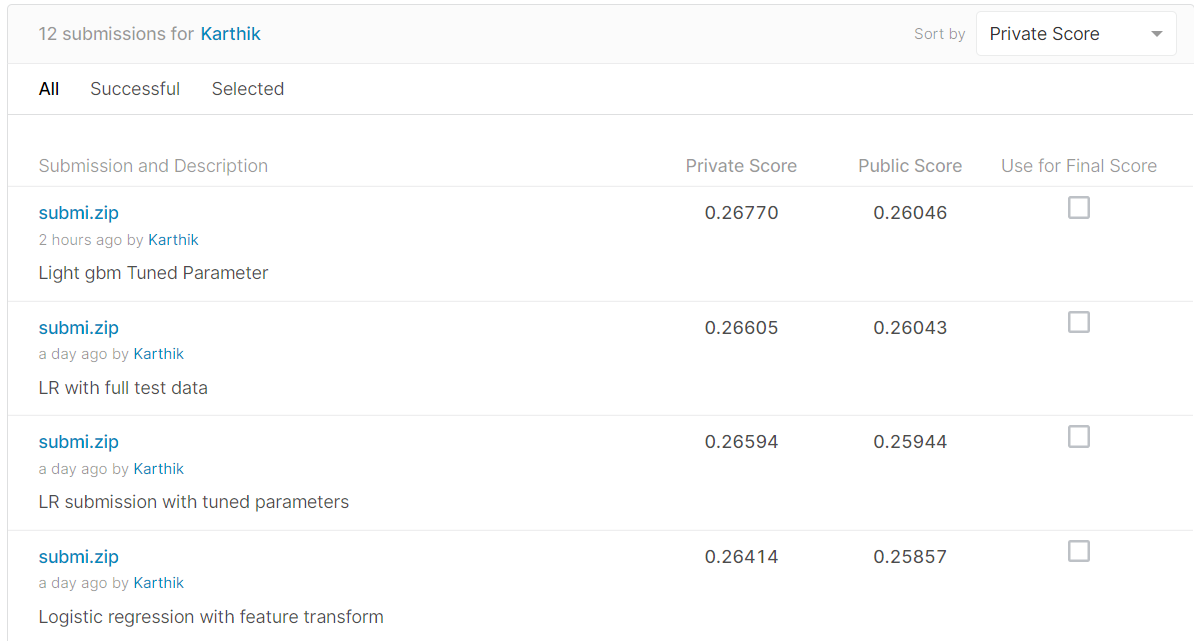

In [55]:
from IPython.display import Image, display

listOfImageNames = ['/content/drive/MyDrive/cs2/Kagge_competion.PNG']

for imageName in listOfImageNames:
    display(Image(filename=imageName))